## Подгрузка необходимых библиотек

In [71]:
# База
import re
import time
import string
import numpy as np
import pandas as pd
import datetime
pd.options.display.float_format = '{:.2f}'.format
import unicodedata
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from pandarallel import pandarallel
import plotly.express as px
from joblib import Parallel, delayed
tqdm.pandas()
import seaborn as sns
# Работа с NLP
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('universal_tagset')
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Подбор гиперпараметров, метрики, преобразование переменных
import optuna
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.utils import resample
# Дополнительные библиотеки
from functools import partial
from IPython.display import display, HTML
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Подготовка данных для демонстрации сервиса

Так как сервис нужен для демонстрации моделей, а не для реального обучения моделей, то стоит сократить выборку для демонстрационного обучения. В случае, если семпл есть, этот этап нужно пропустить.

In [122]:
data = pd.read_csv("/Users/inreleppik/githubr/toxic-comments-classification/modified_train.csv")

In [123]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799551 entries, 0 to 1799550
Data columns (total 39 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int64  
 1   toxicity                  float64
 2   comment_text              object 
 3   severe_toxicity           float64
 4   obscene                   float64
 5   identity_attack           float64
 6   insult                    float64
 7   threat                    float64
 8   created_date              object 
 9   parent_id                 float64
 10  rating                    object 
 11  funny                     int64  
 12  wow                       int64  
 13  sad                       int64  
 14  likes                     int64  
 15  disagree                  int64  
 16  sexual_explicit           float64
 17  identity_annotator_count  int64  
 18  toxicity_annotator_count  int64  
 19  text_length               int64  
 20  year                    

In [124]:
data.head()

,id,toxicity,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,created_date,parent_id,...,threat_b,sexual_explicit_b,toxicity_any_kind,num_words,num_sent,num_punct,tokens,tokens_cnt,tokens_ws,ctws
0,5118044,0.98,You can stick your dick up anyone's butt. Why ...,0.13,0.94,0.01,0.25,0.01,2017-04-10 23:30:10.076014+00:00,NaN,...,0,1,1,17,2,3,"['you', 'can', 'stick', 'your', 'dick', 'up', ...",15,"['stick', 'dick', 'anyone', 'butt', 'law']",stick dick anyone butt law
1,5380193,0.98,I bet your fat bitter little nerd ass was wait...,0.20,0.94,0.02,0.97,0.02,2017-06-08 18:24:06.236150+00:00,5377903.00,...,0,1,1,30,2,4,"['i', 'bet', 'your', 'fat', 'bitter', 'little'...",28,"['bet', 'fat', 'bitter', 'little', 'nerd', 'as...",bet fat bitter little nerd as wait day find wa...
2,5292392,0.95,I hope you die today. The world will be much b...,0.25,0.08,0.01,0.76,0.86,2017-05-23 18:10:27.505027+00:00,5292009.00,...,1,0,1,20,2,2,"['i', 'hope', 'you', 'die', 'today', 'the', 'w...",18,"['hope', 'die', 'today', 'world', 'much', 'goo...",hope die today world much good without filth like
3,5481314,0.91,Let them die ..\nMaybe we should build concent...,0.28,0.01,0.05,0.10,0.88,2017-06-26 21:37:55.561744+00:00,5480942.00,...,1,0,1,22,1,7,"['let', 'them', 'die', 'maybe', 'we', 'should'...",18,"['let', 'die', 'maybe', 'build', 'concentratio...",let die maybe build concentration camp gas cha...
4,5588434,0.94,If we shoot them it will be a permanent soluti...,0.15,0.00,0.03,0.50,0.91,2017-07-13 21:15:03.037890+00:00,5586783.00,...,1,0,1,19,2,2,"['if', 'we', 'shoot', 'them', 'it', 'will', 'b...",17,"['shoot', 'permanent', 'solution', 'creature',...",shoot permanent solution creature waste space


In [125]:
data['toxic'] = (data['toxicity'] >= 0.4).astype(int)

In [126]:
data['toxic'].value_counts(normalize=True)

toxic
0   0.89
1   0.11
Name: proportion, dtype: float64

In [127]:
data = data[['toxic', 'comment_text']]

In [128]:
data.head()

,toxic,comment_text
0,1,You can stick your dick up anyone's butt. Why ...
1,1,I bet your fat bitter little nerd ass was wait...
2,1,I hope you die today. The world will be much b...
3,1,Let them die ..\nMaybe we should build concent...
4,1,If we shoot them it will be a permanent soluti...


Были оставлены только основные колонки для обучения моделей. Теперь пришло время сделать выборку поменьше из исходных данных.

In [130]:
type_count = data['toxic'].value_counts()
sample_size = 100000

type_o_size = int(sample_size * type_count[0] / len(data))
type_t_size = sample_size - type_o_size 

ordinary_sample = resample(data[data['toxic'] == 0], n_samples=type_o_size, random_state=42)
toxic_sample = resample(data[data['toxic'] == 1], n_samples=type_t_size, random_state=42)

s_data = pd.concat([ordinary_sample, toxic_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

In [131]:
s_data['toxic'].value_counts(normalize=True)

toxic
0   0.89
1   0.11
Name: proportion, dtype: float64

In [132]:
s_data.head()

,toxic,comment_text
0,0,Why do I get the feeling this bridge will cost...
1,0,Great work! I hope you take it further. A mo...
2,0,I do not agree with the policies on the right ...
3,0,The Denver Post has not been a reliable news s...
4,1,""" In the meantime, the party is taking advanta..."


Теперь можно сохранить датасет и приступить к этапу EDA и обучению ML моделей.

In [134]:
s_data.to_csv('demo_data.csv')

# EDA

In [3]:
s_data = pd.read_csv('demo_data.csv', index_col=0)

In [5]:
s_data

,toxic,comment_text
0,0,Why do I get the feeling this bridge will cost...
1,0,Great work! I hope you take it further. A mo...
2,0,I do not agree with the policies on the right ...
3,0,The Denver Post has not been a reliable news s...
4,1,""" In the meantime, the party is taking advanta..."
...,...,...
99995,0,"""It was for me like 'you give so much. You giv..."
99996,0,He voted you the gold star as well. Like our l...
99997,0,Comey would likely wimp out on providing any i...
99998,0,How many exactly?


In [7]:
%%time
pandarallel.initialize(progress_bar=True)

s_data[['text_length', 'num_words', 'num_sent', 'num_punct']] = s_data['comment_text'].parallel_apply(
    lambda text: (
        len(text),
        len(nltk.tokenize.word_tokenize(text)),
        len(nltk.tokenize.sent_tokenize(text)),
        sum(ch in string.punctuation for ch in text)
    )
).apply(pd.Series)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


CPU times: user 3.36 s, sys: 172 ms, total: 3.53 s
Wall time: 5.97 s


In [8]:
s_data.head()

,toxic,comment_text,text_length,num_words,num_sent,num_punct
0,0,Why do I get the feeling this bridge will cost...,374,76,3,11
1,0,Great work! I hope you take it further. A mo...,869,178,7,20
2,0,I do not agree with the policies on the right ...,192,38,3,3
3,0,The Denver Post has not been a reliable news s...,149,25,1,1
4,1,""" In the meantime, the party is taking advanta...",279,54,3,10


## Интерактивный график распределения длины текста и количества пунктуации

In [ ]:
%%time
import plotly.subplots as sp
import plotly.graph_objects as go

# Метрики для анализа
metrics = ['text_length', 'num_words', 'num_sent', 'num_punct']
metric_names = {
    'text_length': 'Character Length',
    'num_words': 'Word Length',
    'num_sent': 'Sentence Length',
    'num_punct': 'Number of Punctuations'
}

# Функция для вычисления статистики
def calculate_statistics(data, metric):
    return {
        "mean": data[metric].mean(),
        "median": data[metric].median(),
        "max": data[metric].max(),
        "min": data[metric].min()
    }

# Создаем subplot
fig = sp.make_subplots(
    rows=1, cols=2, 
    subplot_titles=["Non-Toxic Comments", "Toxic Comments"], 
    horizontal_spacing=0.1
)

# Функция для добавления гистограмм
def add_histograms(metric):
    toxic_data = s_data[s_data['toxic'] == 1][metric]
    non_toxic_data = s_data[s_data['toxic'] == 0][metric]

    # Гистограмма для обычных комментариев
    fig.add_trace(go.Histogram(
        x=non_toxic_data,
        name=f'Non-Toxic ({metric_names[metric]})',
        marker_color='powderblue',
        opacity=0.75,
        visible=(metric == metrics[0]),  # Только первая метрика видима по умолчанию
        xbins=dict(size=5)
    ), row=1, col=1)
    
    # Гистограмма для токсичных комментариев
    fig.add_trace(go.Histogram(
        x=toxic_data,
        name=f'Toxic ({metric_names[metric]})',
        marker_color='crimson',
        opacity=0.75,
        visible=(metric == metrics[0]),  # Только первая метрика видима по умолчанию
        xbins=dict(size=5)
    ), row=1, col=2)

# Добавляем гистограммы для всех метрик
for metric in metrics:
    add_histograms(metric)

# Создание кнопок для переключения
buttons = []
for i, metric in enumerate(metrics):
    visible = [False] * len(metrics) * 2  # Изначально всё скрыто
    visible[i * 2] = True  # Включаем non-toxic для текущей метрики
    visible[i * 2 + 1] = True  # Включаем toxic для текущей метрики

    # Статистика для аннотаций
    non_toxic_stats = calculate_statistics(s_data[s_data['toxic'] == 0], metric)
    toxic_stats = calculate_statistics(s_data[s_data['toxic'] == 1], metric)

    # Динамические аннотации
    annotations = [
        dict(
            x=0.0, y=-0.2, xref='paper', yref='paper', showarrow=False,
            text=(
                f"Non-Toxic:\nMean: {non_toxic_stats['mean']:.2f}, "
                f"Median: {non_toxic_stats['median']:.2f}, "
                f"Max: {non_toxic_stats['max']}, Min: {non_toxic_stats['min']}"
            ),
            font=dict(size=12),
            align='center'
        ),
        dict(
            x=1.0, y=-0.2, xref='paper', yref='paper', showarrow=False,
            text=(
                f"Toxic:\nMean: {toxic_stats['mean']:.2f}, "
                f"Median: {toxic_stats['median']:.2f}, "
                f"Max: {toxic_stats['max']}, Min: {toxic_stats['min']}"
            ),
            font=dict(size=12),
            align='center'
        )
    ]

    buttons.append(dict(
        label=metric_names[metric],
        method='update',
        args=[
            {'visible': visible},  # Включаем только текущую метрику
            {
                'annotations': annotations,  # Обновляем аннотации
                'yaxis.autorange': True,  # Автоматически подстраиваем ось y
                'yaxis2.autorange': True,
                'title': f"Distribution of {metric_names[metric]} by Toxicity"
            }
        ]
    ))

# Настройки графика
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            direction="down",
            showactive=True,
            x=1.3,
            y=1.15
        )
    ],
    title="Distribution of Comment Lengths",
    xaxis_title="Length",
    yaxis_title="Count",
    height=600,
    width=1100
)
fig.update_layout(
    title={
        'text': "Distribution of Comment Lengths",
        'x': 0.43,  # Центрирование по горизонтали
        'xanchor': 'center',  # Указание якоря
        'yanchor': 'top'      # Указание вертикального якоря
    }
)

fig.show()


## Обработка текста

In [12]:
class PreprocessLemmaTokenizer:
    def __init__(self):
        self.wnl = nltk.stem.WordNetLemmatizer()
        self.tknzr = nltk.tokenize.TweetTokenizer()
        self.stopwords = set(nltk.corpus.stopwords.words('english'))
        self.punctuation = set(string.punctuation)


        self.url_re = re.compile(r'(https?://\S+|www\.\S+)', re.IGNORECASE)
        self.symbols_re = re.compile(r'[^a-zA-Zа-яА-Я0-9\s]')
        self.spaces_re = re.compile(r'\s+')

    @staticmethod
    def _normalize(doc):
        return unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    @staticmethod
    def _get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return nltk.corpus.wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return nltk.corpus.wordnet.VERB
        elif treebank_tag.startswith('N'):
            return nltk.corpus.wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return nltk.corpus.wordnet.ADV
        else:
            return nltk.corpus.wordnet.NOUN

    def _clean_txt(self, text):
        # удаление ссылок
        c_t = self.url_re.sub('', text.lower())
        # удаление лишних символов
        c_t = self.symbols_re.sub(' ', c_t)
        c_text = self.spaces_re.sub(' ', c_t).strip()
        return c_text

    def __call__(self, doc):
        clean_doc = self._normalize(self._clean_txt(doc))
        tokens = self.tknzr.tokenize(clean_doc)
        
        # Токенизация, удаление стоп-слов, знаков пунктуации и лемматизация
        pos_tags = nltk.pos_tag(tokens)
        return [
            self.wnl.lemmatize(token, pos=self._get_wordnet_pos(pos_tag))
            for token, pos_tag in pos_tags
            if token.lower() not in self.stopwords and token not in self.punctuation
        ]

In [13]:
%%time
pandarallel.initialize(progress_bar=True)

s_data['tokens_ws'] = s_data['comment_text'].parallel_apply(PreprocessLemmaTokenizer())
s_data['ctws'] = s_data.tokens_ws.progress_apply(lambda x: ' '.join(x))

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


  0%|          | 0/100000 [00:00<?, ?it/s]

CPU times: user 969 ms, sys: 283 ms, total: 1.25 s
Wall time: 18.5 s


In [14]:
s_data.head()

,toxic,comment_text,text_length,num_words,num_sent,num_punct,tokens_ws,ctws
0,0,Why do I get the feeling this bridge will cost...,374,76,3,11,"[get, feeling, bridge, cost, u, far, suppose, ...",get feeling bridge cost u far suppose 1million...
1,0,Great work! I hope you take it further. A mo...,869,178,7,20,"[great, work, hope, take, moratorium, breed, y...",great work hope take moratorium breed year wou...
2,0,I do not agree with the policies on the right ...,192,38,3,3,"[agree, policy, right, however, violence, neve...",agree policy right however violence never answ...
3,0,The Denver Post has not been a reliable news s...,149,25,1,1,"[denver, post, reliable, news, source, ever, s...",denver post reliable news source ever since si...
4,1,""" In the meantime, the party is taking advanta...",279,54,3,10,"[meantime, party, take, advantage, exist, rule...",meantime party take advantage exist rule inclu...


## График частоты частей речи

In [16]:
pos_tags_dict = {
    'NN': 'noun, singular',
    'JJ': 'adjective',
    'NNS': 'noun, plural',
    'RB': 'adverb',
    'VBP': 'verb, present tense, not 3rd person singular',
    'VBG': 'present participle or gerund',
    'VBD': 'verb, past tense',
    'VB': 'infinitive',
    'CD': 'numeral',
    'VBN': 'past participle',
    'IN': 'preposition or subordinating conjunction',
    'VBZ': 'verb, present tense, 3rd person singular',
    'MD': 'modal verb',
    'JJR': 'adjective, comparative',
    'NNP': 'proper noun, singular',
    'PRP': 'personal pronoun',
    'JJS': 'adjective, superlative',
    'DT': 'determiner (article, demonstrative pronoun)',
    'RBR': 'adverb, comparative',
    'FW': 'foreign word',
    'CC': 'coordinating conjunction',
    'RP': 'particle',
    'WDT': 'wh-determiner',
    'UH': 'interjection',
    'WP$': 'wh-possessive pronoun',
    'RBS': 'adverb, superlative',
    '$': 'dollar sign',
    'WRB': 'wh-adverb',
    'NNPS': 'proper noun, plural',
    'WP': 'wh-pronoun',
    'PRP$': 'possessive pronoun',
    'POS': 'possessive ending',
    'EX': 'existential "there"',
    'SYM': 'symbol',
    'TO': 'preposition "to"',
    "''": 'closing quotation mark',
    '``': 'opening quotation mark',
    'PDT': 'predeterminer',
    'LS': 'list item marker'
}

In [21]:
%%time
def process_tokens(tokens):
    pos_tags = nltk.pos_tag(tokens, lang='eng')
    pos = [tag for _, tag in pos_tags]
    return pos

# обработка данных с toxicity_b == 0
all_pos_o = Parallel(n_jobs=-1)(delayed(process_tokens)(tokens) for tokens in s_data[s_data.toxic == 0]['tokens_ws'])
all_pos_o = [tag for pos_list in all_pos_o for tag in pos_list]  # Объединение всех списков
pos_cnt_o = Counter(all_pos_o)
translated_counter_o = Counter({pos_tags_dict.get(tag, tag): count for tag, count in pos_cnt_o.items()})

# обработка данных с toxicity_b == 1
all_pos_t = Parallel(n_jobs=-1)(delayed(process_tokens)(tokens) for tokens in s_data[s_data.toxic == 1]['tokens_ws'])
all_pos_t = [tag for pos_list in all_pos_t for tag in pos_list]  # Объединение всех списков
pos_cnt_t = Counter(all_pos_t)
translated_counter_t = Counter({pos_tags_dict.get(tag, tag): count for tag, count in pos_cnt_t.items()})

CPU times: user 2.56 s, sys: 349 ms, total: 2.91 s
Wall time: 12.3 s


In [22]:
%%time
most_common_pos_o = translated_counter_o.most_common(20)
most_common_pos_t = translated_counter_t.most_common(20)

CPU times: user 25 μs, sys: 2 μs, total: 27 μs
Wall time: 27.9 μs


In [ ]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(1,2, figsize = (20, 8))

sns.barplot(
    y=[pos for pos, _ in most_common_pos_o],
    x=[count for _, count in most_common_pos_o]
,ax = axes[0], color = 'powderblue')

sns.barplot(
    y=[pos for pos, _ in most_common_pos_t],
    x=[count for _, count in most_common_pos_t]
,ax = axes[1], color = 'crimson')

axes[0].set_title('Frequency of parts of speech (excluding stop words) for ordinary comments',
                 fontsize = 14)
axes[1].set_title('Frequency of parts of speech (excluding stop words) for toxic comments',
                 fontsize = 14)
axes[0].set_ylabel('Part of speech', fontsize = 12)
axes[1].set_ylabel('Part of speech', fontsize = 12)

axes[0].set_xlabel('Number', fontsize = 14)
axes[1].set_xlabel('Number', fontsize = 14)

axes[0].grid(True)
axes[1].grid(True)
plt.tight_layout()
plt.show()

## Интерактивные графики частоты слов

In [25]:
%%time
from itertools import chain, islice

def extract_features(tokens_series, ngram_sizes=(2, 3)):
    # Объявляем уникальные слова и n-граммы
    unique_words = set(chain.from_iterable(tokens_series))
    unique_ngrams = {n: set() for n in ngram_sizes}

    # Функция для извлечения n-грамм из одного набора токенов
    def extract_ngrams(tokens, n):
        return {' '.join(gram) for gram in nltk.ngrams(tokens, n)}

    # Параллельная обработка каждого размера n-граммы для каждого набора токенов
    for n in ngram_sizes:
        ngrams_for_size = Parallel(n_jobs=-1)(delayed(extract_ngrams)(tokens, n) for tokens in tokens_series if len(tokens) >= n)
        # Объединяем все уникальные n-граммы для текущего размера n
        unique_ngrams[n].update(set(chain.from_iterable(ngrams_for_size)))

    return unique_words, unique_ngrams

# non-toxic
tokens_non_toxic = s_data.loc[s_data.toxic == 0, 'tokens_ws']
uawo, ngrams_non_toxic = extract_features(tokens_non_toxic)
bos = list(ngrams_non_toxic[2])
tos = list(ngrams_non_toxic[3])

# toxic
tokens_toxic = s_data.loc[s_data.toxic == 1, 'tokens_ws']
uawt, ngrams_toxic = extract_features(tokens_toxic)
bts = list(ngrams_toxic[2])
tts = list(ngrams_toxic[3])

uawo = list(uawo)
uawt = list(uawt)

CPU times: user 4.24 s, sys: 291 ms, total: 4.53 s
Wall time: 4.54 s


In [26]:
def get_tfd(unique_tokens, cleaned_com_t, gram):
    # Определяем параметр ngram_range для CountVectorizer
    if gram >= 2:
        vectorizer = CountVectorizer(vocabulary=unique_tokens, ngram_range=(gram, gram))
    else:
        vectorizer = CountVectorizer(vocabulary=unique_tokens)
    
    # Функция для обработки части данных
    def process_chunk(chunk):
        X_chunk = vectorizer.fit_transform(chunk)
        return np.asarray(X_chunk.sum(axis=0))[0]
    
    # Распараллеливаем обработку частей
    n_jobs = -1  # Используем все доступные ядра
    chunk_size = len(cleaned_com_t) // abs(n_jobs)  # Размер части данных для каждого ядра
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_chunk)(cleaned_com_t[i:i + chunk_size]) 
        for i in range(0, len(cleaned_com_t), chunk_size)
    )
    
    # Объединяем результаты
    total_counts = np.sum(results, axis=0)
    return dict(zip(vectorizer.get_feature_names_out(), total_counts))

In [27]:
%%time
token_frequency_dict1 = get_tfd(uawo, s_data[s_data.toxic == 0]['ctws'], 1)
token_frequency_dict12 = get_tfd(uawt, s_data[s_data.toxic == 1]['ctws'], 1)
token_frequency_dict2 = get_tfd(bos, s_data[s_data.toxic == 0]['ctws'], 2)
token_frequency_dict22 = get_tfd(bts, s_data[s_data.toxic == 1]['ctws'], 2)
token_frequency_dict3 = get_tfd(tos, s_data[s_data.toxic == 0]['ctws'], 3)
token_frequency_dict32 = get_tfd(tts, s_data[s_data.toxic == 1]['ctws'], 3)

CPU times: user 3.85 s, sys: 249 ms, total: 4.1 s
Wall time: 13.6 s


In [28]:
data = {
    "Unigram": {
        "ordinary": token_frequency_dict1,
        "toxic": token_frequency_dict12
    },
    "Bigram": {
        "ordinary": token_frequency_dict2,
        "toxic": token_frequency_dict22
    },
    "Trigram": {
        "ordinary": token_frequency_dict3,
        "toxic": token_frequency_dict32
    }
}

In [ ]:
%%time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import base64
import io
import pandas as pd

def generate_wordcloud_base64(frequency_dict):
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(frequency_dict)
    buffer = io.BytesIO()
    wordcloud.to_image().save(buffer, format="PNG")
    buffer.seek(0)
    return f"data:image/png;base64,{base64.b64encode(buffer.read()).decode()}"

# Создание интерактивного графика
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.5, 0.5],
    row_heights=[0.5, 0.5],
    specs=[[{"type": "bar"}, {"type": "bar"}], [{"type": "image"}, {"type": "image"}]],
    subplot_titles=("Ordinary Barplot", "Toxic Barplot", "", "")
)

# Списки для управления видимостью
image_configs = []  # Конфигурация для каждого облака слов

for i, (ngram_type, frequencies) in enumerate(data.items()):
    # Преобразование данных в DataFrame
    ordinary_df = pd.DataFrame(list(frequencies["ordinary"].items()), columns=["word", "count"]).sort_values(by="count", ascending=False).head(30)
    toxic_df = pd.DataFrame(list(frequencies["toxic"].items()), columns=["word", "count"]).sort_values(by="count", ascending=False).head(30)
    
    # Barplots
    fig.add_trace(
        go.Bar(
            x=ordinary_df["count"],
            y=ordinary_df["word"],
            orientation='h',
            marker=dict(color='powderblue'),
            name=f"{ngram_type} Ordinary",
            visible=(i == 0)
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Bar(
            x=toxic_df["count"],
            y=toxic_df["word"],
            orientation='h',
            marker=dict(color='crimson'),
            name=f"{ngram_type} Toxic",
            visible=(i == 0)
        ),
        row=1, col=2
    )
    
    # Word Clouds
    ordinary_wordcloud = generate_wordcloud_base64(frequencies["ordinary"])
    toxic_wordcloud = generate_wordcloud_base64(frequencies["toxic"])
    
    image_configs.append(
        [
            dict(
                source=ordinary_wordcloud,
                xref="paper", yref="paper",
                x=-0.03, y=0.1,  # Левый нижний угол для Ordinary Word Cloud
                sizex=0.55, sizey=0.4,
                xanchor="left", yanchor="bottom",
                layer="above"
            ),
            dict(
                source=toxic_wordcloud,
                xref="paper", yref="paper",
                x=0.51, y=0.1,  # Правый нижний угол для Toxic Word Cloud
                sizex=0.55, sizey=0.4,
                xanchor="left", yanchor="bottom",
                layer="above"
            )
        ]
    )

# Изначально добавляем изображения для первого n-грамма
fig.update_layout(images=image_configs[0])

# Кнопки переключения
buttons = []
for i, ngram_type in enumerate(data.keys()):
    visibility = [False] * len(fig.data)
    visibility[i * 2] = True       # Bar "ordinary"
    visibility[i * 2 + 1] = True   # Bar "toxic"
    
    buttons.append(
        dict(
            label=ngram_type,
            method="update",
            args=[
                {"visible": visibility},  # Управляем видимостью barplot
                {"images": image_configs[i]}  # Обновляем layout.images
            ]
        )
    )

# Добавление выпадающего меню
fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction="down",
            showactive=True,
            x=0.5,
            y=1.09,
            xanchor="center",
            yanchor="top"
        )
    ]
)

# Настройка макета
fig.update_layout(
    plot_bgcolor="white",  # Белый фон для области графиков
    paper_bgcolor="white",  # Белый фон для всего layout
    #xaxis=dict(showgrid=True, gridcolor="lightgray"),  # Сетка с серым цветом
    #yaxis=dict(showgrid=True, gridcolor="lightgray"),
    height=1000,
    width=1200,
    title="Bar Plots and Word Clouds for N-grams",
    showlegend=False
)

# Показ графика
fig.show()

Графики barplot для триграмм немного накладываются друг на друга, но думаю это можно подправить уже на этапе Streamlit

# ML

In [32]:
df = s_data[['toxic', 'ctws']]

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X = s_data['ctws']
y = s_data['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [35]:
from sklearn.preprocessing import MaxAbsScaler  
from sklearn.metrics import classification_report

In [36]:
%%time

vec = CountVectorizer()
vec.fit(X_train)
bow_train = vec.transform(X_train)
bow_test = vec.transform(X_test)

scaler = MaxAbsScaler()
bow_train = scaler.fit_transform(bow_train)
bow_test = scaler.transform(bow_test)

model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

model.fit(bow_train, y_train)
preds = model.predict(bow_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     17765
           1       0.55      0.70      0.62      2235

    accuracy                           0.90     20000
   macro avg       0.76      0.81      0.78     20000
weighted avg       0.92      0.90      0.91     20000

CPU times: user 3.93 s, sys: 813 ms, total: 4.75 s
Wall time: 2.57 s


In [37]:
%%time
model1 = Pipeline([
    ('vectorizer', CountVectorizer()), 
    ('scaler', MaxAbsScaler()),                          
    ('classifier', LogisticRegression(C=1, max_iter=1000, class_weight='balanced', random_state=42))
])

model1.fit(X_train, y_train)

preds = model1.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     17765
           1       0.55      0.70      0.62      2235

    accuracy                           0.90     20000
   macro avg       0.76      0.81      0.78     20000
weighted avg       0.92      0.90      0.91     20000

CPU times: user 2.99 s, sys: 922 ms, total: 3.91 s
Wall time: 1.73 s


In [38]:
%%time

model2 = Pipeline([
    ('vectorizer', CountVectorizer()),                 
    ('scaler', MaxAbsScaler()),                       
    ('classifier', LinearSVC(random_state=42, class_weight='balanced'))  
])

model2.fit(X_train, y_train)

preds = model2.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     17765
           1       0.53      0.65      0.58      2235

    accuracy                           0.90     20000
   macro avg       0.74      0.79      0.76     20000
weighted avg       0.91      0.90      0.90     20000

CPU times: user 36.1 s, sys: 2.86 s, total: 39 s
Wall time: 5.11 s


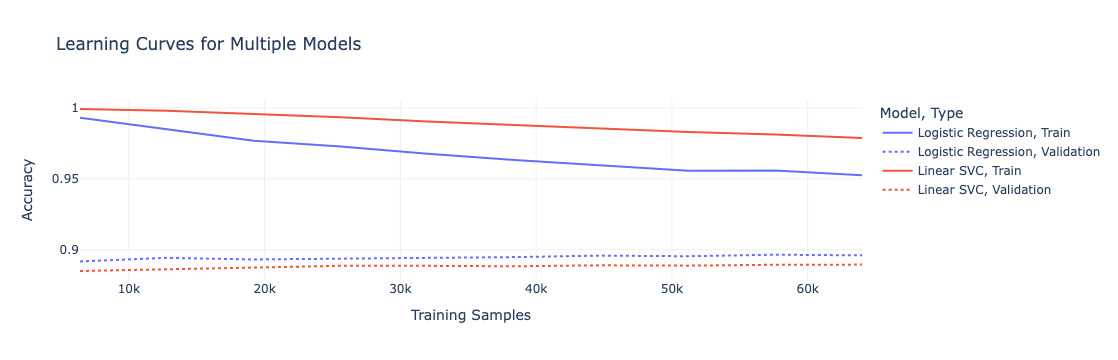

CPU times: user 12min 47s, sys: 1min 51s, total: 14min 39s
Wall time: 3min 12s


In [65]:
%%time
import plotly.express as px
def get_learning_curve_data(estimator, model_name, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Создание DataFrame для объединённого хранения данных
    data = pd.DataFrame({
        "Training Size": np.concatenate([train_sizes, train_sizes]),
        "Score": np.concatenate([train_mean, test_mean]),
        "Type": ["Train"] * len(train_mean) + ["Validation"] * len(test_mean),
        "Model": [model_name] * (2 * len(train_mean))
    })
    return data

# Создание пайплайнов
pipeline_lr = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('scaler', MaxAbsScaler()),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

pipeline_svc = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('scaler', MaxAbsScaler()),
    ('classifier', LinearSVC(random_state=42, class_weight='balanced'))
])

# Получение данных для всех моделей
data_lr = get_learning_curve_data(pipeline_lr, "Logistic Regression", X_train, y_train)
data_svc = get_learning_curve_data(pipeline_svc, "Linear SVC", X_train, y_train)

# Объединение данных всех моделей в один DataFrame
all_data = pd.concat([data_lr, data_svc])

# Построение графика с plotly.express
fig = px.line(
    all_data,
    x="Training Size",
    y="Score",
    color="Model",
    line_dash="Type",
    title="Learning Curves for Multiple Models",
    labels={"Score": "Accuracy", "Training Size": "Training Samples"},
    template="plotly_white"
)

# Отображение графика
fig.show()

In [ ]:
%%time
def get_pr_curve_data(model, model_name, X_test, y_test):
    # Получение вероятностей или решений
    if hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        y_scores = model.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    return pd.DataFrame({
        "Precision": precision,
        "Recall": recall,
        "Model": model_name
    })

pipeline_lr.fit(X_train, y_train)
pipeline_svc.fit(X_train, y_train)
model1.fit(X_train, y_train)

# Получение данных для PR-кривых
data_lr = get_pr_curve_data(pipeline_lr, "Logistic Regression", X_test, y_test)
data_svc = get_pr_curve_data(pipeline_svc, "Linear SVC", X_test, y_test)
data_model1 = get_pr_curve_data(model1, "Logistic Regression_2", X_test, y_test)

# Объединение данных всех моделей в один DataFrame
all_data = pd.concat([data_lr, data_svc, data_model1])

# Построение PR-кривой с plotly.express
fig = px.line(
    all_data,
    x="Recall",
    y="Precision",
    color="Model",
    title="Precision-Recall Curves for Multiple Models",
    labels={"Precision": "Precision", "Recall": "Recall"},
    template="plotly_white"
)

fig.update_layout(
    width=900,  # Ширина графика
    height=800, # Высота графика (равна ширине для квадратного графика)
    title={
        "x": 0.5,  # Центрирование заголовка
        "xanchor": "center"
    },
    xaxis=dict(scaleanchor="y")  # Обеспечение одинакового масштаба для осей X и Y
)

# Отображение графика
fig.show()

In [ ]:
%%time
from sklearn.metrics import roc_curve, roc_auc_score

def get_roc_curve_data(model, model_name, X_test, y_test):
    # Получение вероятностей или решений
    if hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        y_scores = model.predict_proba(X_test)[:, 1]
    
    # Вычисление FPR, TPR и порогов
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    
    # Создание DataFrame с правильными именами
    return pd.DataFrame({
        "False Positive Rate": fpr,
        "True Positive Rate": tpr,
        "Model": model_name,
        "AUC": [auc] * len(fpr)  # Для аннотаций
    })

data_lr = get_roc_curve_data(pipeline_lr, "Logistic Regression", X_test, y_test)
data_svc = get_roc_curve_data(pipeline_svc, "Linear SVC", X_test, y_test)

# Объединение данных всех моделей в один DataFrame
all_data = pd.concat([data_lr, data_svc])

fig = px.line(
    all_data,
    x="False Positive Rate",
    y="True Positive Rate",
    color="Model",
    title="ROC Curves for Multiple Models",
    labels={"False Positive Rate": "False Positive Rate", "True Positive Rate": "True Positive Rate"},
    template="plotly_white",
    color_discrete_sequence=["#636EFA", "#EF553B"]  # Цвета
)

# Добавление AUC в заголовок графика
fig.update_layout(
    annotations=[
        dict(
            x=0.8,
            y=0.2 + i * 0.1,
            xref="paper",
            yref="paper",
            text=f"{model}: AUC={all_data[all_data['Model'] == model]['AUC'].iloc[0]:.2f}",
            showarrow=False,
            font=dict(size=12)
        )
        for i, model in enumerate(all_data["Model"].unique())
    ],
    width=850,
    height=750,
    xaxis=dict(scaleanchor="y")
)

# Отображение графика
fig.show()

In [43]:
def plot_roc_curves(models, X_test, y_test):
    """
    Построение объединённых ROC-кривых для нескольких моделей.

    Параметры:
        models (list of tuples): Список моделей в формате [(модель, название), ...].
        X_test (array): Тестовые данные.
        y_test (array): Истинные метки классов.

    Вывод:
        График ROC-кривых с аннотацией AUC.
    """
    def get_roc_curve_data(model, model_name, X_test, y_test):
        """Вычисление данных для ROC-кривой одной модели."""
        # Получение вероятностей или решений
        if hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
        else:
            y_scores = model.predict_proba(X_test)[:, 1]

        # Вычисление FPR, TPR и AUC
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc = roc_auc_score(y_test, y_scores)
        
        return pd.DataFrame({
            "False Positive Rate": fpr,
            "True Positive Rate": tpr,
            "Model": model_name,
            "AUC": [auc] * len(fpr)
        })

    # Сбор данных ROC-кривых для всех моделей
    all_data = pd.concat([
        get_roc_curve_data(model, name, X_test, y_test) for model, name in models
    ])

    # Построение ROC-кривой
    fig = px.line(
        all_data,
        x="False Positive Rate",
        y="True Positive Rate",
        color="Model",
        title="ROC Curves for Multiple Models",
        labels={"False Positive Rate": "False Positive Rate", "True Positive Rate": "True Positive Rate"},
        template="plotly_white",
        color_discrete_sequence=px.colors.qualitative.Set1  # Палитра цветов
    )

    # Добавление AUC в заголовок графика
    fig.update_layout(
        annotations=[
            dict(
                x=0.8,
                y=0.2 + i * 0.1,
                xref="paper",
                yref="paper",
                text=f"{model}: AUC={all_data[all_data['Model'] == model]['AUC'].iloc[0]:.2f}",
                showarrow=False,
                font=dict(size=12)
            )
            for i, model in enumerate(all_data["Model"].unique())
        ],
        width=850,
        height=750,
        xaxis=dict(scaleanchor="y")
    )

    # Отображение графика
    fig.show()

In [ ]:
models = [
    (model1, "Logistic Regression"),
    (model2, "Linear SVC")
]

# Построение ROC-кривых
plot_roc_curves(models, X_test, y_test)